In [1]:
# IMPORTS

import random
from neuron import h, gui
from neuron.units import ms, mV, um, V, cm
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm

from time import time
import os.path

from socket import gethostname

%config InlineBackend.figure_formats = ['svg']

h.load_file('basal_project.hoc')

1.0

In [2]:
# BARDIA CELL INITIATION (ALTERED)

# spine_neck = None
# spine_head = None
# spine_neck, spine_head = add_spines(h.a1_111)

ratio=0
loc=10
nsyn=0
sec=h.a1_111

dendrec=True

print(f'\n%s .... Starting Run' % (gethostname()))
iotim = 0
tic = time()

h.tstop = 500
h.synrec = 1

h.tsamp = h.tstop/h.dt+1
h.synrec = 1
tsamp = int(h.tsamp)

r = h.Random(h.luckyoffset)
r.negexp(h.meanisi)

# Stimulated branch
# syn = h.synsuper(.5, r, sec=sec)
# syndict = dict(sloc=loc, ratio=ratio, e1flag=0)
# for name, value in syndict.items(): 
#     setattr(syn.syn, name, value)

# Initialize nseg with 'active' branches

# h.a1_111.nseg = int(np.floor(h.a1_111.L))
# h.a1_111.nseg = int(np.floor(h.a1_111.L)/2)
seclist = [h.a1_111]
sl2 = h.SectionList()
for sec in seclist:
    sl2.append(sec = sec)
poppedsecs = sl2.unique()
h.refreshnseg(h.makeactivelist(sl2))
print(f'nseg: %d' % (h.nsegcnt()))
h.cvode.cache_efficient(1)
h.cvode_active(0)

# somatic voltage recordings, after nseg initialization
v = h.Vector(tsamp)
v.record(h.soma(.5)._ref_v)
trash = v.label(h.soma.name())

# Voltage Recording Dictionary
vd = {'s':v}

if dendrec:
    
    # Dendritic Voltage Recording 
    
    h.distance(0, h.soma_con_pt, sec=h.soma)
    d = h.distance(0, sec=sec)
    locx = (loc - d)/sec.L
    v = h.Vector(tsamp)
    v.record(sec(locx)._ref_v)
    trash = v.label(sec.name())
    vd.update({'d':v})

h.poisson = 0

# 'background' current injection
# ic = h.IClamp(1,sec=h.soma)
# ic.dur = h.tstop


# p_tstart = 100 # plot tstart, crop initial rising phase of current injection
# ind_tstart = p_tstart/h.dt
# t = np.arange(0,h.tstop-p_tstart+h.dt,h.dt)
# fh = plt.figure(figsize=(4,8))
# for runcnt, icamp in enumerate(icamps):
#     runcnt = 1
#     ic.amp = icamp
#     syn.syn.nsyn = nsyn
#     seed1 = float(686)
#     r1 = h.Random(seed1)
#     r1.negexp(h.meanisi)
#     syn.setrand(r1)

#     # run simulation
#     h.run()

#     postrunrecgather(vd)

#     # plot voltage and synaptic current
#     ax = fh.add_subplot(6,1,runcnt+3)
#     ax.plot(t,np.array(vd['d'])[ind_tstart:],c='k',lw=1)
#     ax = fh.add_subplot(6,1,runcnt+5)
#     ax.plot(t,-(vd['nis'].sum(0)+vd['ais'].sum(0))[ind_tstart:],c='r',lw=1)
# plt.show()

dend_v = h.Vector().record(h.a1_111(0.8)._ref_v)
t = h.Vector().record(h._ref_t)
    
# h.finitialize()
h.run()

plt.plot(t, dend_v)
    
plt.xlabel('Time (ms)')
plt.ylabel('mV') 
plt.show()
stim=[]


Christophers-MacBook-Pro.local .... Starting Run
nseg: 329


ValueError: segment position range is 0 <= x <= 1

In [9]:
######################### BIOPHYSICAL FUNCTIONS #########################

def add_spines(branch):
    spine_head = []
    spine_neck = []
    
    n_spines = branch.nseg * 5
    
    for i in range(n_spines):
        spine_head.append(h.Section())
        spine_neck.append(h.Section())

        spine_head[-1].L = 0.5
        spine_head[-1].diam = 0.5
        spine_head[-1].Ra = 100
        spine_head[-1].insert('pas')
        for seg in spine_head[-1]:
            seg.pas.e = -70
            seg.pas.g = 0.00005

        spine_neck[-1].L = 1.5
        spine_neck[-1].diam = 0.25
        spine_neck[-1].Ra = 100
        spine_neck[-1].insert('pas')
        for seg in spine_neck[-1]:
            seg.pas.e = -70
            seg.pas.g = 0.00005

        spine_neck[-1].connect(branch((i+1)/n_spines))
        spine_head[-1].connect(spine_neck[-1])
    return spine_neck, spine_head

def add_syn():
    
    """
    Adds AMPA and NMDA synaptic channels to the dendrite shaft
    """

    syn_ampa = []
    syn_nmda = []
    n_spines = len(spine_head)
    for i in range(n_spines):
        syn_ampa.append(h.Exp2Syn(spine_head[i](0.5)))
        syn_nmda.append(h.Exp2SynNMDA(spine_head[i](0.5)))
        syn_ampa[-1].e = 0
        syn_ampa[-1].tau1 = 0.05
        syn_ampa[-1].tau2 = 0.5
        syn_nmda[-1].e = 0
        syn_nmda[-1].tau1 = 2.1
        syn_nmda[-1].tau2 = 18.8
    
    return syn_ampa, syn_nmda


def input_res(axs, branch):
    
    """
    Injects current into dendrite and spine head
    Measures voltage response (at dendrite site)
    The resistance is calculated using Ohm's Law
    """
    
    d_v = []
    s_v = []
    
    h.tstop = 30
    h.v_init = -70
    
    for i in tqdm(range(branch.nseg)):
        pos = (i+1)/branch.nseg
        
        i_stim = h.IClamp(branch(pos))
        i_stim.dur=30
        i_stim.delay=2
        i_stim.amp=0.1
        
        v_vec = h.Vector().record(branch(pos-0.001)._ref_v)
        
#         h.finitialize()
        h.run()
        
        d_v.append(np.amax(np.array(v_vec)))
        
        i_stim = None
        v_vec = None
    
    for j in tqdm(range(branch.nseg)):
        pos = (j+1)/branch.nseg
        spine_pos = (j * 5) + 4
        
        s_stim = h.IClamp(spine_head[spine_pos](0))
        s_stim.dur = 30
        s_stim.delay = 2
        s_stim.amp = 0.1  # 0.1 nA
        
        v_vec = h.Vector().record(branch(pos-0.001)._ref_v)
        
#         h.finitialize()
        h.run()
        
        s_v.append(np.amax(np.array(v_vec)))
        
        s_stim = None
        v_vec = None
        
    plt.figure(figsize=(8,4))
    s_r = (np.array(s_v)+70)/0.1    # mV/nA = MOhms
    i_r = (np.array(d_v)+70)/0.1
    distance = list(range(1, branch.nseg + 1, 1))
    
    axs.plot(distance, i_r, 
                label='Shaft', 
                color='blue')

    axs.plot(distance, s_r, 
                label='Spine', 
                color='red')
    
    axs.legend()
    axs.set_xlabel('Distance along branch (µm)')
    axs.set_ylabel('Input Resistance (MΩ)')
    
    # SOMA Input Resistance
        
    soma_stim = h.IClamp(h.soma(0.5))
    soma_stim.dur = 30
    soma_stim.delay = 2
    soma_stim.amp = 0.1  # 0.1 nA
        
    volt = h.Vector().record(h.soma(0.6)._ref_v)
        
    h.run()
    
    volt_max = np.amax(np.array(volt))
    soma_r = (volt_max + 70)/0.1
        
    soma_stim = None
    volt = None
    
    print('Soma Input Resistance: ' + str(soma_r) + ' MΩ')
    
    return soma_r

def space_plot(branch):

    plt.figure()
    n_segs = branch.nseg

    time_steps = int(h.tstop/h.dt + 1)
    v_array = np.zeros((1, time_steps), dtype=float)

    for i in range(n_segs):

        loc = i/n_segs

        if i > 0:
            v_array = np.vstack([v_array, np.zeros((1, time_steps), dtype=float)])

        v = h.Vector().record(branch(loc)._ref_v)
        t_vec = h.Vector().record(h._ref_t)

        h.run()

        v_array[-1, :] = v
    

    x = np.linspace(0, np.floor(branch.L), n_segs)
    v_mean = v_array.mean(axis=1)
    plt.plot(x, v_mean)
    plt.xlabel('Distance (um)')
    plt.ylabel('Voltage Response (mV)')
    plt.title('Voltage Space Plot')

######################### CURRENT INJECTIONS ############################

def current_inject(current, plot=False):
    h.v_init = -70
    h.tstop = 500
    
    clamp = []
    clamp = h.IClamp(h.soma(1))
    clamp.delay = 0
    clamp.dur = 1e9
    clamp.amp = current
    
    soma_v = h.Vector().record(h.soma(0.5)._ref_v)
    t_vec = h.Vector().record(h._ref_t)
    
    h.finitialize()
    h.run()
    
    if plot:
        plt.plot(t_vec, soma_v)
        plt.title('Voltage Trace with Current Injection (' + str(current) + ' nA)')
        plt.xlabel('Time (ms)')
        plt.ylabel('Somatic Voltage (mV)')
    
    clamp = None

    freq = frequency_counter(t_vec, soma_v)
    return freq

def frequency_counter(t_vec, v_vec):
    t_tot = t_vec[-1]
    
    spike_counter = 0
    length_v = len(v_vec)
    for i in range(0, length_v-1):
        if v_vec[i] < 0 and v_vec[i+1] >= 0:
            spike_counter += 1
    
    frequency = (spike_counter/t_tot) * 10 ** 3
    
    return frequency


def fi_curve(max_c, inc, mean, var, avg):
    
    """
    Generates an FI curve through injecting increasing current into the soma
    
    max_c: the maximum amount of injected current at the soma (nA)
    inc: the size step of the amount of current (nA)
    mean: the mean amount of noisy current (nA)
    var: the variance of the noisy current (nA^2)
    avg: the number of times each FI point will be averaged along the curve
    """
    
    h.tstop = 1000 # ms
    h.v_init = -70 # mV
    
    frequency_list = []
    
    tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
    current = np.random.normal(mean, var, len(tt))
    
    i_c = h.Vector()
    i_c.from_python(current)
    stim_obj = h.IClamp(h.soma(0.5))
    stim_obj.delay = 0 # ms
    stim_obj.dur = 1e9 # ms
    i_c.play(stim_obj._ref_amp, tt, True)
    
    for amp in tqdm(np.linspace(0, max_c, int(max_c/inc + 1))):
        
        f_trial = []
        
        for j in range(avg):
            
            temp = []
            temp = h.IClamp(h.soma(1))
            temp.delay = 0
            temp.dur = 1e9
            temp.amp = amp
        
            soma_v = h.Vector().record(h.soma(1)._ref_v)
            t_vec = h.Vector().record(h._ref_t)
            h.finitialize()
            h.run()
            
            plt.plot(t_vec, soma_v)
            
            stim = None
            temp = None
            
            f_trial.append(frequency_counter(t_vec, soma_v))
        
        frequency = np.mean(np.array(f_trial))
        frequency_list.append(frequency)
    
    amp_list = np.linspace(0, max_c, int(max_c/inc + 1))
    
    i_c = None
    stim_obj = None

    return amp_list, frequency_list

##################### SYNAPSE BEHAVIOR ##########################

def create_stim(interval=10, num=3, start=5, noise=0, s=1):
    
    """
    Creates a stimulator object used as the pre-synaptic stimulus
    interval: amount of time between stimulation events (ms)
    num: the number of stimulation events
    start: delay of stimulation (ms)
    s: seed number
    """
    
    stim = h.NetStim()
    stim.interval = interval
    stim.number = num
    stim.start = start
    stim.noise = noise
    stim.seed(s)
    
    return stim
    
def random_syns(n_syn, 
                g, 
                stim, 
                branch,
                stagger,
                syns,
                cluster=1,
                axs=0, 
                visual=False, 
                weight=False,
                volt=False):
    
    
    """
    Description: random syns is used to produce histograms of firing rate for
    a poisson process of synapses
    num_syn: The number of synapses stimulating the dendrite (int)
    g: Conductance of NMDA and AMPA synapse (list) (uS)
    stim: Stimulation object
    axs: Axes plot handles used to plot depolarization graphs
    visual: Determines whether to display a visual of the synaptic placement
    c_index: Yields the index value for the cluster size
    """
    
    if visual:
        ax_v = axs[1]
        ax_d = axs[0]
    else:
        ax_v = axs
    
    h.tstop = 1000
    h.v_init = -70
    
    ncstim = []
    index_v = []
    
    if stagger:
        stim = []
        stagger_start = 0
        for i in range(6):
            temp_stim = create_stim(interval=1000/50,
                       num=1e9,
                       start=stagger_start,
                       noise=1,
                       s=1)
            stim.append(temp_stim)
            stagger_start += 3
    else:
        stim = create_stim(interval=1000/50,
                       num=1e9,
                       start=0,
                       noise=1,
                       s=1)
        
    tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
    current = np.random.normal(0.75, 1, len(tt))

    i_c = h.Vector()
    i_c.from_python(current)
    stim_obj = h.IClamp(h.soma(0.5))
    stim_obj.delay = 0  # ms
    stim_obj.dur = 1e9  # ms
    i_c.play(stim_obj._ref_amp, tt, True)
    
    stim_order = np.array([0, 1, 2, 3, 4, 5])
    np.random.shuffle(stim_order)
    stagger_count = 0
    for i, is_syn in enumerate(syns):
        
        if is_syn:
            for c in range(cluster):
                if stagger:

                    ncstim.append(h.NetCon(stim[stim_order[stagger_count]], syn_ampa[i*5+c-1], 0, 0, g[0]))
                    ncstim.append(h.NetCon(stim[stim_order[stagger_count]], syn_nmda[i*5+c-1], 0, 0, g[1]))
                    stagger_count += 1
                else:

                    # conductance is in units of uS
                    ncstim.append(h.NetCon(stim, syn_ampa[i*5+c-1], 0, 0, g[0]))
                    ncstim.append(h.NetCon(stim, syn_nmda[i*5+c-1], 0, 0, g[1]))
                    
    
    
    soma_v = h.Vector().record(h.soma(0.5)._ref_v)
    t_vec = h.Vector().record(h._ref_t)
    h.finitialize()
    h.run()

    if volt:
        fig, ax_v = plt.subplots()
        ax_v.plot(t_vec, soma_v)
        ax_v.set(xlabel='Time (ms)',
                ylabel='Voltage (mV)',
                title='Voltage Trace for Staggered Firing')
        ax_v.grid()
        
    
    f = frequency_counter(t_vec, soma_v)
    stagger_stim = None
    ncstim = None
    stim = None
    current = None
    stim = None
    i_c = None
    stim_obj = None
        
    return f, syns

def random_syns_hist(n_syn, 
                     g, 
                     stim, 
                     num_trials, 
                     branch, 
                     keep,
                     cluster=1, 
                     visual=True, 
                     weight=False,
                     stagger=False,
                     volt=False):
    
    if visual:
        fig, ax_d = plt.subplots()
    freqs = []
    dend_length = list(range(branch.nseg))
    lines = range(1, num_trials+1)
    
    scaling_factor = 1 # np.floor(num_trials/5) + 1
    
    syns_keep = np.zeros((1, branch.nseg+1), dtype=float)
    sk = 0
    
    for q in range(num_trials):
        temp_syn = poisson_syn(n_syn=n_syn, 
                    branch=h.a1_111, 
                    cluster=cluster, 
                    start=30, 
                    fix=True)
        
        if q == 0:
            syns_vec = temp_syn
        else:
            syns_vec = np.vstack([syns_vec, temp_syn])
    
    print(np.sum(syns_vec, axis=0))
    
    for y in tqdm(range(num_trials)):
        
        
        syns_loc = syns_vec[y, :]
        f, syns = random_syns(n_syn, 
                              g, 
                              stim, 
                              branch, 
                              stagger,
                              syns_loc,
                              cluster,
                              weight=weight, 
                              volt=volt)
        freqs.append(f)
        
        if int(np.floor(f)) in keep:
            if sk == 0:
                syns_w_f = np.concatenate((syns, f), axis=None)
                syns_keep[-1, :] = syns_w_f
                sk += 1
            else:
                syns_keep = np.vstack([syns_keep, np.zeros((1, branch.nseg+1), dtype=float)])
                syns_w_f = np.concatenate((syns, f), axis=None)
                syns_keep[-1, :] = syns_w_f
                sk += 1
        
        if visual:
            # Plots line that looks like a dendritic wire
            plt.text(branch.nseg + 15, y*scaling_factor, str(np.round(f)))
            y_vals = np.ones(branch.nseg) * y * scaling_factor
            ax_d.plot(dend_length, y_vals, color='blue')
            ax_d.plot(0, y * scaling_factor, marker='o', markersize=15, color='blue')

            index = 0
            for s in syns:
                if s:
                    ax_d.plot(index, y * scaling_factor, marker='o', color='red')
                index += 1
    if visual:
        ax_d.set(xlabel='Distance Along Dendrite (µm)',
                         ylabel='Cluster Size',
                         title='Distribution of ' + str(n_syn) + ' Synapses')
    
    return freqs, syns_keep
    
    
def syn_plotter(n_syn, syns, branch, f, size):
    
    fig, ax_d = plt.subplots(figsize=size)
    dend_length = list(range(branch.nseg))
    num_trials = np.size(syns, axis=0)
    lines = range(1, num_trials+1)
    scaling_factor = 1
    
    for y in range(num_trials):
        
        syns_data = syns[y, 0:-1]
        freq_trial = syns[y, -1]
        
        if np.floor(freq_trial) == f:
            y_vals = np.ones(branch.nseg) * y * scaling_factor
            ax_d.plot(dend_length, y_vals, color='blue')
            ax_d.plot(0, y * scaling_factor, marker='o', markersize=15, color='blue')
            
            index = 0
            for s in syns_data:
                if s:
                    ax_d.plot(index, y*scaling_factor, marker='o', color='red')
                index += 1
    
    ax_d.set(xlabel='Distance Along Dendrite (µm)',
            ylabel='Trials',
            title='Distribution of ' + str(n_syn) + ' Synapses for ' + str(f) +' Hz')

def constant_syn(branch, loc, n_syn, stim, g, spread, plot=True, xlim=1, ylim=1):
    
    loc_n = int(np.floor(len(syn_ampa)*loc))
    loc_um = int(np.floor(branch.L*loc))
    
    print('Applying synapses at ~' + str(loc_um) + ' um (' + str(branch.L) + ' um total)')
    
    h.v_init = -70
    
    ncstim = []

    
    if plot:
        plt.figure(figsize=(10, 8))
    for i in range(n_syn):
        
#         print(loc_n)
#         print(len(syn_ampa))
        
        ncstim.append(h.NetCon(stim, syn_ampa[loc_n+spread*i], 0, 0, g[0]))
        ncstim.append(h.NetCon(stim, syn_nmda[loc_n+spread*i], 0, 0, g[1])) # gMax
        
    soma_v = h.Vector().record(h.soma(0.5)._ref_v)
    t_vec = h.Vector().record(h._ref_t)
        
    h.finitialize()
    h.run()
    if plot:
        plt.plot(t_vec, soma_v, label=str(i+1))
            
    f = frequency_counter(t_vec, soma_v)
    
    if plot:
        plt.legend()
        plt.xlabel('Time (ms)')
        if xlim != 1:
            plt.xlim(xlim[0], xlim[1])
        if ylim != 1:   
            plt.ylim(ylim[0], ylim[1])
        plt.ylabel('Somatic Voltage (mV)')
        plt.title('Increasing Number of Synapses')
    
    ncstim = None
    
    return f 
    
######################### POISSON PROCESSES ##########################

def poisson_syn(n_syn, 
                branch, 
                cluster=1, 
                start=30, 
                fix=True):
    """
    n_syn: Number of syns being simulated
    branch: Branch being simulated
    start: point at which the synapses can start to attach (µm)
    """
    
    incorrect_num = True
    
    if fix:
        while incorrect_num:
            
            n_bins_fix = int(np.floor(  (start/branch.L)*branch.nseg ))
            
            nbins = branch.nseg - n_bins_fix
            prob_of_syn = (n_syn/cluster)/(nbins)
            np.random.seed()
            syns = np.random.rand(nbins) < prob_of_syn
            syns = syns * 1
            no_syns_region = np.zeros(n_bins_fix)
            syns = np.concatenate((no_syns_region, syns), axis=0)
            
            num_events = np.sum(syns)
            if int(num_events) == int(n_syn/cluster):
                incorrect_num = False
                
    else:
        
        nbins = branch.nseg - 30
        prob_of_syn = (n_syn/cluster)/(branch.nseg - 30)
        syns = np.random.rand(nbins) < prob_of_syn
        syns = syns * 1
        no_syns_region = np.zeros(30)
        syns = np.concatenate((no_syns_region, syns), axis=0)
        
    return syns

def poisson_syn_weight(n_syn, branch, cluster=1, start=30, fix=True):
    """
    n_syn: Number of syns being simulated
    branch: Branch being simulated
    start: point at which the synapses can start to attach (µm)
    """
    
    incorrect_num = True
    
    if fix:
        while incorrect_num:
            
            n_bins_fix = int(np.floor(  (start/branch.L)*branch.nseg ))
            
            nbins = branch.nseg - n_bins_fix
            prob_vec = np.linspace(3, 1, nbins)
            sum_prob = np.sum(prob_vec)
            prob_of_syn = n_syn*prob_vec/sum_prob

            syns = np.random.rand(nbins) < prob_of_syn
            syns = syns * 1
            no_syns_region = np.zeros(n_bins_fix)
            syns = np.concatenate((no_syns_region, syns), axis=0)
            
            num_events = np.sum(syns)
            if num_events == int(n_syn/cluster):
                incorrect_num = False
                
    else:
        
        nbins = branch.nseg - 30
        prob_of_syn = (n_syn/cluster)/(branch.nseg - 30)
        syns = np.random.rand(nbins) < prob_of_syn
        syns = syns * 1
        no_syns_region = np.zeros(30)
        syns = np.concatenate((no_syns_region, syns), axis=0)
        
    return syns


def pseudo_histogram(data, n_syn):
    
    unique_vals = np.unique(data)
    counts = []
    for i in unique_vals:
        c = data.count(i)
        counts.append(c)
    
    plt.bar(unique_vals, counts)
    plt.xlabel('Somatic Firing Rate (Hz)')
    plt.ylabel('Relative Frequency (Count)')
    plt.title('Histogram of Firing Rates for ' + str(n_syn ) +' Synapses')
    

######################### BARDIA FUNCTIONS ###########################

def postrunrecgather(vd):
    ags = []
    for a in h.ampaglist:
        ags.append(np.array(a))
    ags = np.array(ags)
    vd.update({'ags':ags})

    ngs = []
    for n in h.nmdaglist:
        ngs.append(np.array(n))
    ngs = np.array(ngs)
    vd.update({'ngs':ngs})

    ais = []
    for a in h.ampailist:
        ais.append(np.array(a))
    ais = np.array(ais)
    vd.update({'ais':ais})

    nis = []
    for n in h.nmdailist:
        nis.append(np.array(n))
    nis = np.array(nis)
    vd.update({'nis':nis})

    nbs = []
    for n in h.nmdablist:
        nbs.append(np.array(n))
    nbs = np.array(nbs)
    vd.update({'nbs':nbs})

    rasind = []
    for s in h.ex_stim_vecs:
        rasind.append(np.array(s))
    vd.update({'rasind':rasind})

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Soma Input Resistance: 20.9038172417074 MΩ


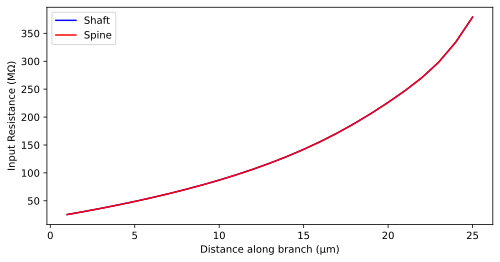

<Figure size 576x288 with 0 Axes>

In [10]:
# INPUT RESISTANCE

spine_neck = None
spine_head = None
spine_neck, spine_head = add_spines(h.a1_111)

fig, axs = plt.subplots(1, 1, figsize=(8,4))
soma_r = input_res(axs, h.a1_111)

In [11]:
# ADD SYNAPSES

syn_ampa, syn_nmda = add_syn()

In [16]:
# RANDOM SYNS

syn_ampa, syn_nmda = add_syn()

h.tstop = 1000

syn_stim=[]
freq, syns = random_syns_hist(n_syn=12,
                 g=[0.00075, 0.00195],
                 stim=syn_stim,
                 num_trials=1000, 
                 branch=h.a1_111,
                 stagger=False,
                 keep =[],
                 cluster=2,
                 visual=False,
                 weight=False,
                 volt=False)

syn_stim = None

[  0.   0.   0. 258. 289. 251. 292. 254. 264. 289. 271. 291. 239. 271.
 286. 295. 265. 280. 284. 284. 294. 259. 272. 268. 244.]


  0%|          | 0/1000 [00:00<?, ?it/s]

6.9080000000025
2.685536000001943


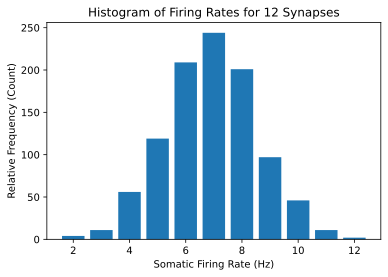

In [17]:
# HISTOGRAM

pseudo_histogram(freq, n_syn=12)
print(np.mean(freq))
print(np.var(freq))

In [18]:
np.savetxt('Cluster2_12FreqPoisson.csv', freq, delimiter=",")
# np.savetxt('Cluster1SynsPoisson.csv', syns, delimiter=",")

# np.save('Cluster1Freq.npy', freq)
# np.save('Cluster1Syns.npy', syns)

In [20]:
# 6 SYNAPSE RUN

syn_ampa, syn_nmda = add_syn()

h.tstop = 1000

syn_stim = create_stim(interval=1000/50,
                       num=1e9,
                       start=0,
                       noise=1,
                       s=2)

num_s = 6
f_vec = []

for i in range(25):
    f = 0
    for u in range(25):
        tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
        current = np.random.normal(0.75, 1, len(tt))

        i_c = h.Vector()
        i_c.from_python(current)
        stim_obj = h.IClamp(h.soma(0.5))
        stim_obj.delay = 0  # ms
        stim_obj.dur = 1e9  # ms
        i_c.play(stim_obj._ref_amp, tt, True)

        f_temp = constant_syn(branch=h.a1_111,
                         loc=i/h.a1_111.nseg,
                         n_syn=num_s,
                         stim=syn_stim,
                         g=[0.0015, 0.0039],
                         spread=0,
                         plot=False)
        
        f = f + f_temp
        current = None
        i_c = None
        stim_obj = None
        
    f_vec.append(f/50)
    
syn_stim = None

Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um total)
Applying synapses at ~0 um (243.8985804846295 um

Applying synapses at ~48 um (243.8985804846295 um total)
Applying synapses at ~48 um (243.8985804846295 um total)
Applying synapses at ~48 um (243.8985804846295 um total)
Applying synapses at ~48 um (243.8985804846295 um total)
Applying synapses at ~48 um (243.8985804846295 um total)
Applying synapses at ~58 um (243.8985804846295 um total)
Applying synapses at ~58 um (243.8985804846295 um total)
Applying synapses at ~58 um (243.8985804846295 um total)
Applying synapses at ~58 um (243.8985804846295 um total)
Applying synapses at ~58 um (243.8985804846295 um total)
Applying synapses at ~58 um (243.8985804846295 um total)
Applying synapses at ~58 um (243.8985804846295 um total)
Applying synapses at ~58 um (243.8985804846295 um total)
Applying synapses at ~58 um (243.8985804846295 um total)
Applying synapses at ~58 um (243.8985804846295 um total)
Applying synapses at ~58 um (243.8985804846295 um total)
Applying synapses at ~58 um (243.8985804846295 um total)
Applying synapses at ~58 um (24

Applying synapses at ~107 um (243.8985804846295 um total)
Applying synapses at ~107 um (243.8985804846295 um total)
Applying synapses at ~107 um (243.8985804846295 um total)
Applying synapses at ~107 um (243.8985804846295 um total)
Applying synapses at ~107 um (243.8985804846295 um total)
Applying synapses at ~107 um (243.8985804846295 um total)
Applying synapses at ~107 um (243.8985804846295 um total)
Applying synapses at ~107 um (243.8985804846295 um total)
Applying synapses at ~107 um (243.8985804846295 um total)
Applying synapses at ~107 um (243.8985804846295 um total)
Applying synapses at ~107 um (243.8985804846295 um total)
Applying synapses at ~117 um (243.8985804846295 um total)
Applying synapses at ~117 um (243.8985804846295 um total)
Applying synapses at ~117 um (243.8985804846295 um total)
Applying synapses at ~117 um (243.8985804846295 um total)
Applying synapses at ~117 um (243.8985804846295 um total)
Applying synapses at ~117 um (243.8985804846295 um total)
Applying synap

Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synapses at ~165 um (243.8985804846295 um total)
Applying synap

Applying synapses at ~214 um (243.8985804846295 um total)
Applying synapses at ~214 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synapses at ~224 um (243.8985804846295 um total)
Applying synap

In [32]:
f = f * 2

Text(0, 0.5, 'Average Firing Rate (Hz)')

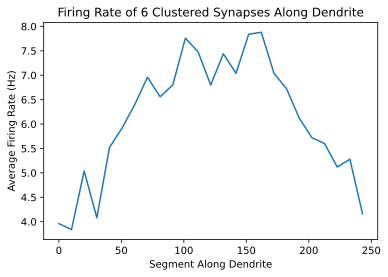

In [33]:
x_dist = np.linspace(0, 243, 25)
plt.plot(x_dist, f)
plt.title('Firing Rate of 6 Clustered Synapses Along Dendrite')
plt.xlabel('Segment Along Dendrite')
plt.ylabel('Average Firing Rate (Hz)')

In [26]:
np.save('Cluster6Spatial.npy', f_vec)

In [41]:
# NOISY CURRENT TESTING

syn_ampa, syn_nmda = add_syn()

h.tstop = 1000

syn_stim = create_stim(interval=1000/50,
                       num=1e9,
                       start=0,
                       noise=1,
                       s=2)

num_s = 0
f_vec = []


for u in range(100):
    tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
    current = np.random.normal(0.75, 1, len(tt))

    i_c = h.Vector()
    i_c.from_python(current)
    stim_obj = h.IClamp(h.soma(0.5))
    stim_obj.delay = 0  # ms
    stim_obj.dur = 1e9  # ms
    i_c.play(stim_obj._ref_amp, tt, True)

    f_temp = constant_syn(branch=h.a1_111,
                     loc=0.5,
                     n_syn=num_s,
                     stim=syn_stim,
                     g=[0.0015, 0.0039],
                     spread=0,
                     plot=False)

    f_vec.append(f_temp)
    current = None
    i_c = None
    stim_obj = None
    
syn_stim = None

Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synapses at ~121 um (243.8985804846295 um total)
Applying synap

0.600000000000217
0.4800000000003473


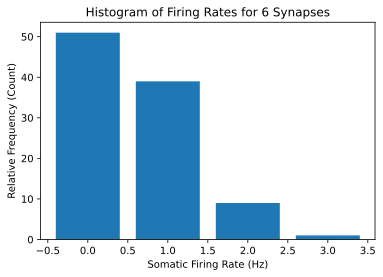

In [42]:
pseudo_histogram(f_vec, n_syn=6)
print(np.mean(f_vec))
print(np.var(f_vec))

In [43]:
np.savetxt('BackgroundFiring.csv', f_vec, delimiter=",")